In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.cuda.is_available()

False

In [4]:
import os
os.chdir("/content/drive/My Drive/SSNE_repo/SSNE/lab3")

In [5]:
device = torch.device("cuda") 
device

device(type='cuda')

In [6]:
df = pd.read_csv('data.csv', delimiter=",")
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,8537.421183,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955,155.552177,191.574132
std,5026.363303,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477,151.039033,181.144454
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4282.250000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,8666.500000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,118.000000,145.000000
75%,13016.750000,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,222.000000,284.000000
max,17093.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000,886.000000,977.000000


In [7]:
df_eval = pd.read_csv('evaluation_data.csv', delimiter=",")
df_eval.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.503619,6.565070,11.555367,0.029108,3.012167,0.685815,1.436778,0.502942,0.480257,0.641252,0.188525
std,1.091258,0.500025,3.429462,6.912526,0.168123,2.002541,0.464226,0.648390,0.196575,0.175655,0.192934,0.123137
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.160000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.490000,0.104500
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.520000,0.500000,0.650000,0.164200
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.810000,0.253700
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.980000,1.000000,1.000000,0.835800


In [8]:
df_cas = df.drop(columns=['dteday', 'cnt', 'registered', 'instant']).astype(float)
df_reg = df.drop(columns=['dteday', 'cnt', 'casual', 'instant']).astype(float)
df_eval = df_eval.drop(columns=['dteday']).astype(float)

In [9]:
df_cas.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955
std,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000
75%,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000


In [10]:
df_reg.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,155.552177
std,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,151.039033
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,36.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,118.000000
75%,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,222.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,886.000000


In [11]:
train_dataset_cas = data.TensorDataset(torch.from_numpy(df_cas.values[:,:-1]).float(), torch.from_numpy(df_cas.values[:,-1]).float())
train_dataset_reg = data.TensorDataset(torch.from_numpy(df_reg.values[:,:-1]).float(), torch.from_numpy(df_reg.values[:,-1]).float())

train_data_loader_cas = data.DataLoader(train_dataset_cas, batch_size=8, shuffle=True)
train_data_loader_reg = data.DataLoader(train_dataset_reg, batch_size=8, shuffle=True)

In [12]:
# df_eval = df_eval.drop(columns=['casual', 'registered', 'cnt', 'instant'])
df_eval

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0,0.26,0.2273,0.56,0.3881
1,1.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0,0.26,0.2727,0.56,0.0000
2,1.0,0.0,1.0,2.0,0.0,4.0,1.0,1.0,0.26,0.2727,0.56,0.0000
3,1.0,0.0,1.0,3.0,0.0,4.0,1.0,1.0,0.26,0.2576,0.56,0.1642
4,1.0,0.0,1.0,4.0,0.0,4.0,1.0,1.0,0.26,0.2576,0.56,0.1642
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1.0,1.0,12.0,19.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642
6489,1.0,1.0,12.0,20.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642
6490,1.0,1.0,12.0,21.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642
6491,1.0,1.0,12.0,22.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343


In [13]:
test_dataset = torch.from_numpy(df_eval.values).float()

In [14]:
test_dataset

tensor([[ 1.0000,  0.0000,  1.0000,  ...,  0.2273,  0.5600,  0.3881],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        ...,
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2576,  0.6000,  0.1642],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.5600,  0.1343],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.6500,  0.1343]])

In [15]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.act_fn = nn.ReLU()
        self.linear1 = nn.Linear(num_inputs, num_hidden1)
        self.linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.linear3 = nn.Linear(num_hidden2, num_outputs)
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        
        x = self.linear2(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

In [16]:
def predict(model, test_batch):
    # predicting for every batch
    test_outputs = []
    test_output = model(test_batch)
    for value in test_output:
        test_outputs.append(value)
            
    # tensor to list
    list_output = []
    for output in test_outputs:
        list_output.append(output.item())
    
    # list to dataframe
    df_output = pd.DataFrame(list_output)
    
    return df_output

In [17]:
def get_trained_model(data_loader, criterion, learning_rate):
    model = SimpleClassifier(num_inputs=12, num_hidden1=48, num_hidden2=48, num_outputs=1)
    model.train() 
    # model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 1000
    train_losses = []

    # Training loop
    for epoch in range(epochs):
        train_loss = 0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            # data_inputs = data_inputs.to(device)
            # data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = criterion(preds, data_labels.float())
            train_loss += loss.item()

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()


        preds_test = model(test_dataset)

        train_losses.append(train_loss/len(data_loader))
        if epoch % 10 == 0:
          print(f"Epoch: {epoch}, loss: {train_loss/len(data_loader)}")

    return model, train_losses

In [18]:
criterion = nn.MSELoss()
learning_rate_cas = 0.0014
learning_rate_reg = 0.0003

In [19]:
%%time
model_cas, train_losses_cas = get_trained_model(train_data_loader_cas, criterion, learning_rate_cas)

Epoch: 0, loss: 1833.2933618908503
Epoch: 10, loss: 560.3700160745485
Epoch: 20, loss: 463.8598633017459
Epoch: 30, loss: 444.4312715845718
Epoch: 40, loss: 398.55293802195484
Epoch: 50, loss: 376.88509639793244
Epoch: 60, loss: 349.25987598599977
Epoch: 70, loss: 346.2956007492183
Epoch: 80, loss: 324.46328956917927
Epoch: 90, loss: 336.8811619339578
Epoch: 100, loss: 315.77711697066206
Epoch: 110, loss: 318.1575300513078
Epoch: 120, loss: 322.95745768816835
Epoch: 130, loss: 299.0218317230163
Epoch: 140, loss: 301.2511921727771
Epoch: 150, loss: 308.6723282605212
Epoch: 160, loss: 295.488877157706
Epoch: 170, loss: 301.769236271737
Epoch: 180, loss: 282.6234129065542
Epoch: 190, loss: 285.42845631311434
Epoch: 200, loss: 289.4607446216468
Epoch: 210, loss: 278.98741801427974
Epoch: 220, loss: 283.9515947419698
Epoch: 230, loss: 274.9165342153652
Epoch: 240, loss: 286.5662812026961
Epoch: 250, loss: 270.22674764385124
Epoch: 260, loss: 277.4566321429043
Epoch: 270, loss: 280.686431824

In [20]:
%%time
model_reg, train_losses_reg = get_trained_model(train_data_loader_reg, criterion, learning_rate_reg)

Epoch: 0, loss: 23702.651625140636
Epoch: 10, loss: 12926.673541672348
Epoch: 20, loss: 11886.1487617801
Epoch: 30, loss: 11190.811807513324
Epoch: 40, loss: 10911.036330941317
Epoch: 50, loss: 10547.318600746396
Epoch: 60, loss: 10350.9495706327
Epoch: 70, loss: 10136.939549565928
Epoch: 80, loss: 9816.950696475711
Epoch: 90, loss: 9597.891991732315
Epoch: 100, loss: 9387.190644891361
Epoch: 110, loss: 9177.514371576246
Epoch: 120, loss: 8729.31694734841
Epoch: 130, loss: 8344.028146097715
Epoch: 140, loss: 7842.51901393669
Epoch: 150, loss: 7325.790564425634
Epoch: 160, loss: 6912.735448311743
Epoch: 170, loss: 6725.873543800281
Epoch: 180, loss: 6200.552505818297
Epoch: 190, loss: 6040.907795588642
Epoch: 200, loss: 5695.050680223587
Epoch: 210, loss: 5367.931087009001
Epoch: 220, loss: 5254.312662582902
Epoch: 230, loss: 4979.601407860413
Epoch: 240, loss: 4730.894608261478
Epoch: 250, loss: 4340.287063329558
Epoch: 260, loss: 4280.080712149548
Epoch: 270, loss: 4050.081746097876
E

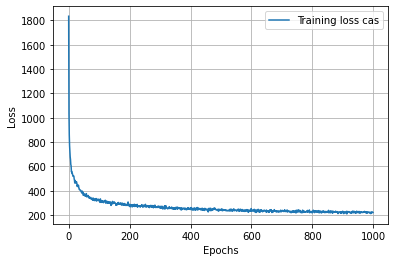

In [21]:
plt.plot(train_losses_cas, label='Training loss cas')
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

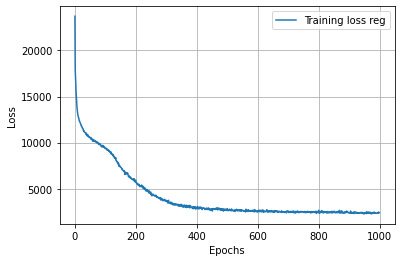

In [22]:
plt.plot(train_losses_reg, label='Training loss reg')
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [23]:
# save models to files
state_dict = model_cas.state_dict()
torch.save(state_dict, "neural_net_cas.tar")

state_dict = model_reg.state_dict()
torch.save(state_dict, "neural_net_reg.tar")

In [24]:
test_dataset

tensor([[ 1.0000,  0.0000,  1.0000,  ...,  0.2273,  0.5600,  0.3881],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        [ 1.0000,  0.0000,  1.0000,  ...,  0.2727,  0.5600,  0.0000],
        ...,
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2576,  0.6000,  0.1642],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.5600,  0.1343],
        [ 1.0000,  1.0000, 12.0000,  ...,  0.2727,  0.6500,  0.1343]])

In [25]:
preds_cas = predict(model_cas, test_dataset)

In [26]:
preds_cas.describe()

,0
count,6493.000000
mean,34.279290
std,44.808194
min,-142.531418
25%,5.484688
50%,17.250031
75%,48.154942
max,326.743958


In [27]:
preds_reg = predict(model_reg, test_dataset)

In [28]:
preds_reg.describe()

,0
count,6493.000000
mean,151.753502
std,139.579562
min,-76.462395
25%,39.453842
50%,117.834435
75%,213.830215
max,814.932556


In [29]:
df_output = preds_cas + preds_reg

In [30]:
# saving to file
df_output.to_csv('muchomorki.csv', header=False, index=False)

In [31]:
df_output.describe()

,0
count,6493.000000
mean,186.032792
std,165.699096
min,-94.736301
25%,46.959051
50%,145.581326
75%,272.099068
max,911.891724


In [32]:
preds_cas = []
labels_cas = []
for data_inputs, data_labels in train_data_loader_cas:
    preds = model_cas(data_inputs)
    preds_cas.append(preds)
    labels_cas.append(data_labels)

preds_cas = torch.cat(preds_cas).detach().numpy()
labels_cas = torch.cat(labels_cas).detach().numpy()

In [33]:
from sklearn.metrics import mean_absolute_error

In [34]:
'LOSS CAS', mean_absolute_error(preds_cas, labels_cas)

('LOSS CAS', 9.031649)

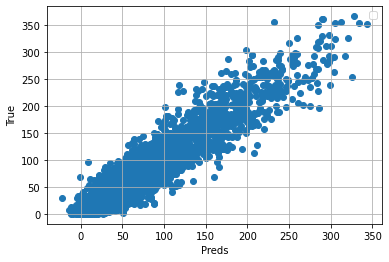

In [35]:
plt.scatter(preds_cas, labels_cas)
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Preds")
plt.ylabel("True")
plt.grid()
plt.legend()

In [36]:
preds_reg = []
labels_reg = []
for data_inputs, data_labels in train_data_loader_reg:
    preds = model_reg(data_inputs)
    preds_reg.append(preds)
    labels_reg.append(data_labels)

preds_reg = torch.cat(preds_reg).detach().numpy()
labels_reg = torch.cat(labels_reg).detach().numpy()

In [37]:
'LOSS REG', mean_absolute_error(preds_reg, labels_reg)

('LOSS REG', 31.859295)

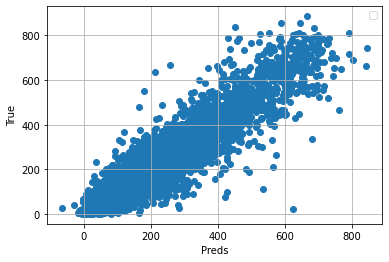

In [38]:
plt.scatter(preds_reg, labels_reg)
# plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Preds")
plt.ylabel("True")
plt.grid()
plt.legend()